In [1]:
import sys   
sys.path.append('../../src/data')
import query_flights as query
path_to_db = "sqlite:///../../data/processed/airlines.db"

In [2]:
# Get Flights For A

In [48]:
from datetime import timedelta

def extract_datetime(dt_string):
    return  pd.to_datetime(dt_string, infer_datetime_format=True)

def round_to_hour(ts):
    return ts.replace(microsecond=0, second=0, minute=0)

def shift_back_hours(ts, hours=3):
    return ts - timedelta(hours=hours)

def exclude_datetime_features(data):
    return data.select_dtypes(exclude=[np.datetime64])

In [36]:
# get_features.py
import numpy as np
import pandas as pd
from datetime import date
from sqlalchemy import create_engine

def query_departing_flights_for_date_range(start_date=None, end_date=None, 
                                           airport_code=None, path_to_db=None):
    """Retrieve recorded flight data for a given time range and airport"""
    if start_date is None:
        start_date = date(2017, 1, 1)
    if end_date is None:
        end_date = date(2017, 1, 31)
    if airport_code is None:
        airport_code = 'MDT'
        
    engine = create_engine(path_to_db)
    with engine.connect() as conn:
        flights = pd.read_sql("""
            SELECT 
                f.departure_was_delayed_15,
                f.origin,
                f.dest,
                f.carrier,
                f.departure_time_scheduled,
                f.distance,
                f.elapsed_time_scheduled
            FROM 
                flights AS f
            WHERE 
                f.Origin = :airport_code
            AND
                f.flight_date 
            BETWEEN :start_date 
                AND :end_date
        """, conn, 
        params={'start_date': start_date, 'end_date': end_date, 'airport_code': airport_code})
      
    flights['departure_time'] = flights['departure_time_scheduled'].apply(extract_datetime)
    flights['departure_month'] = flights['departure_time'].dt.month
    flights['departure_date'] = flights['departure_time'].dt.day
    flights['departure_dow'] = flights['departure_time'].dt.dayofweek
    flights['departure_hod'] = flights['departure_time'].dt.hour
    return flights

def query_weather_for_date_range(start_date=None, end_date=None, 
                                 airport_code=None, path_to_db=None):
    """Retrieve recorded flight data for a given time range and airport"""
    if start_date is None:
        start_date = date(2017, 1, 1)
    if end_date is None:
        end_date = date(2017, 1, 31)
    if airport_code is None:
        airport_code = 'MDT'
        
    engine = create_engine(path_to_db)
    with engine.connect() as conn:
        weather = pd.read_sql("""
            SELECT 
                a.airport,
                w.date,
                w.hourly_visibility,
                w.hourly_dry_bulb_temp_f,
                w.hourly_precipitation,
                w.hourly_wind_speed,
                w.hourly_wind_gust_speed,
                w.hourly_station_pressure
            FROM 
                weather AS w
            JOIN 
                airports as a
            ON a.int_latitude = w.int_latitude 
            AND a.int_longitude = w.int_longitude
            WHERE 
                a.airport = :airport_code
            AND 
                a.airport_is_latest == 1
            AND
                w.date 
            BETWEEN :start_date 
                AND :end_date
        """, conn, 
        params={'start_date': start_date, 'end_date': end_date, 'airport_code': airport_code})
        
    weather['date'] = weather['date'].apply(extract_datetime)
    weather['measurement_hour'] = weather['date'].apply(round_to_hour)
        
    return weather

def get_features_for_flight_analysis(start_date=None, end_date=None, 
                                     airport_code=None, path_to_db=None):
    """Build Features for Analysis of Flights"""
    if start_date is None:
        start_date = date(2017, 1, 1)
    if end_date is None:
        end_date = date(2017, 1, 31)
    if airport_code is None:
        airport_code = 'MDT'
    
    # Get Flights For 
    flights = query_departing_flights_for_date_range(start_date, end_date, airport_code, path_to_db)
    
    # Get Hourly Summaries of Weather
    weather = query_weather_for_date_range(start_date, end_date, airport_code, path_to_db)
    
    return flights, weather

flights, weather = get_features_for_flight_analysis(path_to_db=path_to_db)

In [37]:
flights

,departure_was_delayed_15,origin,dest,carrier,departure_time_scheduled,distance,elapsed_time_scheduled,departure_time,departure_month,departure_date,departure_dow,departure_hod
0,0,MDT,ATL,DL,2017-01-01 06:00:00.000000,620,132,2017-01-01 06:00:00,1,1,6,6
1,0,MDT,ATL,DL,2017-01-11 12:04:00.000000,620,134,2017-01-11 12:04:00,1,11,2,12
2,0,MDT,ATL,DL,2017-01-11 18:08:00.000000,620,136,2017-01-11 18:08:00,1,11,2,18
3,0,MDT,ATL,DL,2017-01-11 05:57:00.000000,620,143,2017-01-11 05:57:00,1,11,2,5
4,1,MDT,ATL,DL,2017-01-12 12:04:00.000000,620,134,2017-01-12 12:04:00,1,12,3,12
5,0,MDT,ATL,DL,2017-01-12 18:08:00.000000,620,136,2017-01-12 18:08:00,1,12,3,18
6,0,MDT,ATL,DL,2017-01-12 05:57:00.000000,620,143,2017-01-12 05:57:00,1,12,3,5
7,0,MDT,ATL,DL,2017-01-13 12:04:00.000000,620,134,2017-01-13 12:04:00,1,13,4,12
8,0,MDT,ATL,DL,2017-01-19 12:04:00.000000,620,134,2017-01-19 12:04:00,1,19,3,12
9,0,MDT,ATL,DL,2017-01-19 18:08:00.000000,620,136,2017-01-19 18:08:00,1,19,3,18


In [54]:
def merge_airport_and_weather(weather, flights, hour_shift=3):

    weather['weather_merge_hour'] = weather['measurement_hour'].apply(lambda x: x + timedelta(hours=hour_shift))
    
    merged = pd.merge(left=flights, right=weather,
                      left_on=['origin', 'departure_time'],
                      right_on=['airport', 'merge_hour'])
    
    return merged
    
merged = merge_airport_and_weather(weather, flights)
merged = exclude_datetime_features(merged)
merged = merged.drop(['departure_time_scheduled', 'airport', 'origin', 'dest', 'carrier'], axis=1)

In [55]:
y = merged['departure_was_delayed_15']
X = merged.drop('departure_was_delayed_15', axis=1)

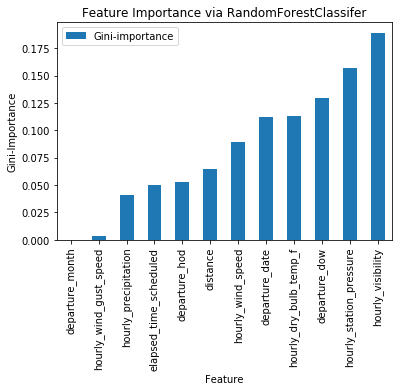

In [59]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

def estimate_feature_importances(X, y, feature_names):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
    forest.fit(X, y)
    
    features = {}
    for feature, importance in zip(feature_names, forest.feature_importances_):
        features[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Gini-importance'})
    
    importances.sort_values(by='Gini-importance').plot(kind='bar')
    plt.xlabel('Feature')
    plt.ylabel('Gini-Importance')
    plt.title('Feature Importance via RandomForestClassifer')
    plt.show()
    return importances

importances = estimate_feature_importances(X=X, y=y, feature_names=X.columns)

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X_train, y_train)

forest.score(X_test, y_test)

0.9285714285714286

<bound method ClassifierMixin.score of ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)>